In [12]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate higher MMR code with regimes
- Eccentricities: Depends on MMR / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 3:1, 5:3, 7:5, 4:1, 5:2, 5:1 / Uniform
- Deltas: Depends on MMR / Uniform
- Planet masses: 0.3 to 30 Earth masses / Uniform log m

In [13]:
# Build lookup dictionaries once for Dynamic e/Delta sampling
mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
minmaxDeltas = pd.DataFrame(
    mmr_list, columns=['mmr']
)

minmaxDeltas['min_Delta_used'] = [0.010, 0.005, 0.0025, 0.010, 0.005, 0.015]
minmaxDeltas['max_Delta_used'] = [0.030, 0.015, 0.0075, 0.030, 0.015, 0.030]
minDelta_lookup = dict(zip(minmaxDeltas['mmr'], minmaxDeltas['min_Delta_used']))
maxDelta_lookup = dict(zip(minmaxDeltas['mmr'], minmaxDeltas['max_Delta_used']))

minmaxDeltas['min_Loge_used'] = [-1.5, -1.5, -1.7, -1.3, -1.3, -1.0]
minmaxDeltas['max_Loge_used'] = [-0.5] * 6
minLoge_lookup = dict(zip(minmaxDeltas['mmr'], minmaxDeltas['min_Loge_used']))
maxLoge_lookup = dict(zip(minmaxDeltas['mmr'], minmaxDeltas['max_Loge_used']))

# Show df
minmaxDeltas.head()

,mmr,min_Delta_used,max_Delta_used,min_Loge_used,max_Loge_used
0,3:1,0.0100,0.0300,-1.5,-0.5
1,5:3,0.0050,0.0150,-1.5,-0.5
2,7:5,0.0025,0.0075,-1.7,-0.5
3,4:1,0.0100,0.0300,-1.3,-0.5
4,5:2,0.0050,0.0150,-1.3,-0.5


In [14]:
# Create 3000 samples per MMR
Nsize = 3000
mstar = 1
P1 = 7
validity_threshold = 100

mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
rows = []

for i,mmr in enumerate(mmr_list):
    while len(rows) < (i+1)*Nsize:
        Loge_low = minLoge_lookup[mmr]
        Loge_high = maxLoge_lookup[mmr]
        e1 = 10 ** np.random.uniform(Loge_low, Loge_high)
        e2 = 10 ** np.random.uniform(Loge_low, Loge_high)
        w1 = np.random.uniform(0, 360)
        w2 = np.random.uniform(0, 360)

        Delta_low = minDelta_lookup[mmr]
        Delta_high = maxDelta_lookup[mmr]
        Delta = np.random.uniform(Delta_low, Delta_high) * np.random.choice([-1, 1])

        j, jminusN = mmr.split(":")  # Extract j:j-N
        j = int(j)
        N = j - int(jminusN)
        P2 = P1 * (Delta + 1) * j / (j-N)
    
        m1 = 10 ** np.random.uniform(-0.5, 1.5)
        m2 = 10 ** np.random.uniform(-0.5, 1.5)
        mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
        mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value
    
        e_max = max(e1, e2)
        validity1 = Delta**2 / (mu2 * e_max)
        validity2 = Delta**2 / (mu1 * e_max)
    
        if (validity1 > validity_threshold) and (validity2 > validity_threshold):
            rows.append([
                e1, w1, e2, w2, Delta, mmr, j, N, P1, P2,
                m1, m2, mu1, mu2, validity1, validity2
            ])

df = pd.DataFrame(
    rows,
    columns=[
        'e1','w1','e2','w2',
        'Delta','mmr','j','N',
        'P1','P2',
        'm1','m2','mu1','mu2',
        'validity1','validity2'
    ]
)
df['valid'] = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = df['valid'].mean() * 100
df.head()

,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.047400,100.700641,0.217648,119.317930,-0.021691,3:1,3,2,7,20.544486,1.209026,2.173868,0.000004,0.000007,331.092631,595.315253,True
1,0.164720,302.045726,0.068150,303.935202,0.017168,3:1,3,2,7,21.360529,3.932763,3.664654,0.000012,0.000011,162.568618,151.485795,True
2,0.240904,196.166685,0.042103,127.431653,0.021325,3:1,3,2,7,21.447826,3.099576,0.429561,0.000009,0.000001,1463.134849,202.771682,True
3,0.078053,285.258275,0.049500,192.127677,0.018148,3:1,3,2,7,21.381102,12.754481,4.651202,0.000038,0.000014,302.036944,110.144400,True
4,0.265350,58.254765,0.175747,166.960578,-0.016945,3:1,3,2,7,20.644161,1.778444,0.546847,0.000005,0.000002,658.806422,202.573839,True


In [15]:
# # Create 2500 samples per MMR
# size = 2500
# mstar = 1

# # MMR -> j, N Sampling
# mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
# mmr = np.random.choice(mmr_list, size=size)
# mmrparts = np.char.split(mmr, ':')  # Extract j:j-N
# j = np.array([int(p[0]) for p in mmrparts])
# N = np.array([int(p[0]) - int(p[1]) for p in mmrparts])

# # Dynamic Delta sampling
# mmr_conds = [(mmr == ratio) for ratio in mmr_list]
# Delta_mins = [0.010, 0.005, 0.0025, 0.010, 0.005, 0.015]
# Delta_maxes = [0.030, 0.015, 0.0075, 0.030, 0.015, 0.030]

# Delta_low = np.select(mmr_conds, [mn for mn in Delta_mins], default=0.05)
# Delta_high = np.select(mmr_conds, [mx for mx in Delta_maxes], default=0.10)
# Delta = np.random.uniform(low=Delta_low, high=Delta_high, size=size) * np.random.choice([-1, 1], size=size)

# # Dynamic e sampling
# loge_mins = [-1.5, -1.5, -1.7, -1.3, -1.3, -1.0]
# loge_low = np.select(mmr_conds, [loge for loge in loge_mins], default=-2)
# loge_high = -0.5

# e1 = 10 ** np.random.uniform(low=loge_low, high=loge_high, size=size)
# e2 = 10 ** np.random.uniform(low=loge_low, high=loge_high, size=size)
# w1 = np.random.uniform(low=0, high=360, size=size)
# w2 = np.random.uniform(low=0, high=360, size=size)

# # Everything else
# P1 = 7
# P2 = P1 * (Delta + 1) * j / (j-N)

# m1 = 10 ** np.random.uniform(low=-0.5, high=1.5, size=size)
# m2 = 10 ** np.random.uniform(low=-0.5, high=1.5, size=size)

# mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
# mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

# e_max = np.maximum(e1, e2)
# validity1 = Delta**2 / (mu2 * e_max)
# validity2 = Delta**2 / (mu1 * e_max)
# validity_threshold = 100

# # Create valid mask
# valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
# valid_percent = valid.mean() * 100

# # Compile to dataframe
# df = pd.DataFrame({
#     'e1': e1, 'w1': w1,
#     'e2': e2, 'w2': w2,
#     'Delta': Delta,
#     'mmr': mmr, 'j': j, 'N': N,
#     'P1': 7, 'P2': P2,
#     'm1': m1, 'm2': m2,
#     'mu1': mu1, 'mu2': mu2,
#     'validity1': validity1, 'validity2': validity2,
#     'valid': valid
# })
# df.head()

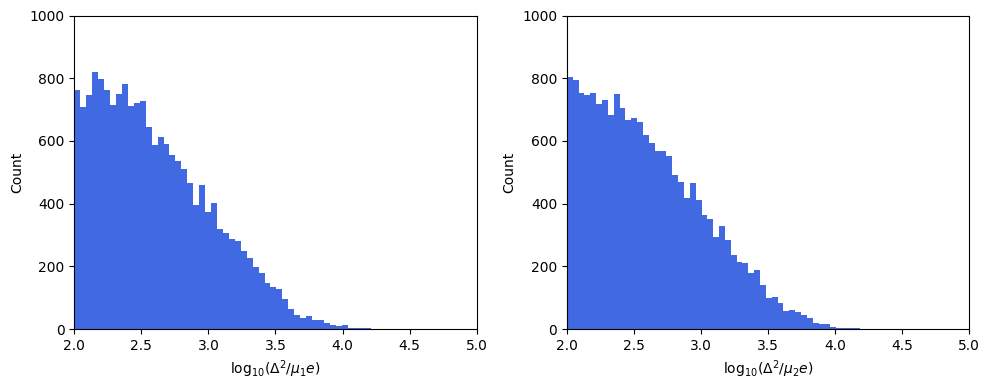

In [16]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (2, 5); ylim = (0, 1000)

v1 = df['validity1'].to_numpy()
v2 = df['validity2'].to_numpy()
valid = (df['valid'] == True).to_numpy()

# Left histogram
ax[0].hist([np.log10(v1[valid]), np.log10(v1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
# ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(v2[valid]), np.log10(v2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
# ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
# Export dataframe (Also remove invalid columns to save space)
df[(df.valid == True)].to_csv("deckagol_TTVFast_params.csv", index=False)